In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
from copy import deepcopy
from pathlib import Path

from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np

import scipy
import scipy.stats
import scipy.integrate

import torch
import torch.distributions

import sbi
import sbi.analysis as analysis
from sbi.inference import SNRE_A, SNRE_B, prepare_for_sbi
from sbi.utils.get_nn_models import classifier_nn

import cnre

## setup

In [3]:
num_training_samples = 2_000
num_validation_samples = 2_000
num_total_samples = num_training_samples + num_validation_samples
num_posterior_samples = 2_000

train_kwargs = dict(
    training_batch_size=128,
    learning_rate=1e-4,
    validation_fraction=0.5,
    stop_after_epochs=2 ** 31 - 1,
    max_num_epochs=300,
    clip_max_norm=None,
)

classifier_kwargs = dict(
    model='resnet', 
    hidden_features=50, 
    num_blocks=2,
    dropout_probability=0.0,
    use_batch_norm=True
)
sample_with = "rejection"

device = "cpu"
root = Path("figures")

In [4]:
dimension = 4
low = -torch.ones(dimension).mul(3.).sqrt().to(device)
high = torch.ones(dimension).mul(3.).sqrt().to(device)
limits = torch.stack([low.cpu(), high.cpu()], dim=-1).numpy()

prior = sbi.utils.BoxUniform(low=low, high=high, device=device)

kind = "parabola"
if kind == "parabola":
    task = cnre.Parabola(scale=0.1)
elif kind == "gaussian":
    task = cnre.Gaussian(scale=0.1)
else:
    raise NotImplementedError

simulator, prior = prepare_for_sbi(task.simulate, prior)

true_theta = torch.ones(dimension).to(device).unsqueeze(0)
observation = simulator(true_theta)

theta = prior.sample((num_total_samples,)).to(device)
x = simulator(theta).to(device)

## ratio estimation

In [5]:
get_classifier = classifier_nn(**classifier_kwargs)

inference = SNRE_A(
    prior, 
    classifier=get_classifier,
)
_ = inference.append_simulations(theta.cpu(), x.cpu()).train(**train_kwargs)

inference._neural_net.load_state_dict(inference._best_model_state_dict)
density_estimator = deepcopy(inference._neural_net)

posterior = inference.build_posterior(
    density_estimator,
    sample_with=sample_with,
)

 Training neural network. Epochs trained: 301

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

                        may take a long time to collect the remaining 1999
                        samples. Consider interrupting (Ctrl-C) and switching to
                        `sample_with='mcmc`.


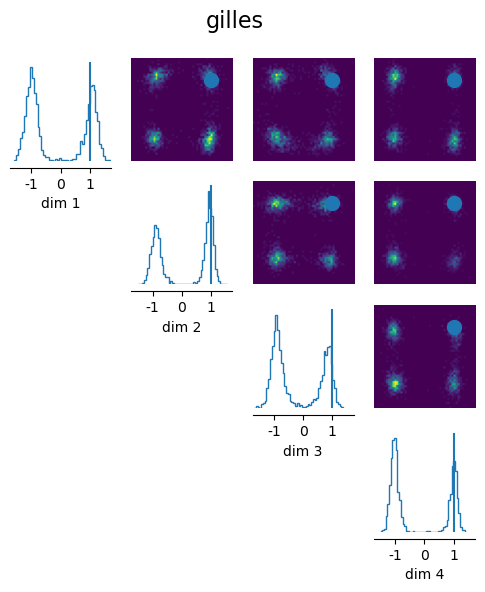

In [6]:
samples = posterior.sample((num_posterior_samples,), x=observation.cpu())
name = "gilles"
fig, _ = analysis.pairplot(
    samples.cpu().numpy(), 
    figsize=(6,6), 
    points=true_theta.cpu().numpy(),
    title=name,
    limits=limits,
)

## durkan

In [7]:
get_classifier = classifier_nn(**classifier_kwargs)

inference = SNRE_B(
    prior, 
    classifier=get_classifier,
)
_ = inference.append_simulations(theta.cpu(), x.cpu()).train(num_atoms=2, **train_kwargs)

inference._neural_net.load_state_dict(inference._best_model_state_dict)
density_estimator = deepcopy(inference._neural_net)

posterior = inference.build_posterior(
    density_estimator,
    sample_with=sample_with,
)

 Training neural network. Epochs trained: 301

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

                        may take a long time to collect the remaining 1999
                        samples. Consider interrupting (Ctrl-C) and switching to
                        `sample_with='mcmc`.


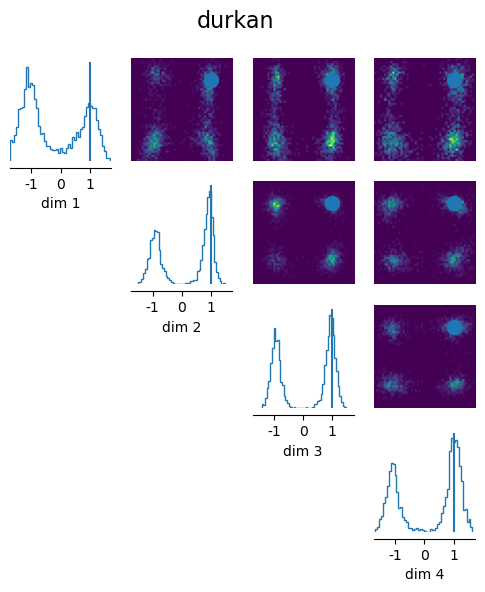

In [8]:
samples = posterior.sample((num_posterior_samples,), x=observation.cpu())
name = "durkan"
fig, _ = analysis.pairplot(
    samples.cpu().numpy(), 
    figsize=(6,6), 
    points=true_theta.cpu().numpy(),
    title=name,
    limits=limits,
)